In [2]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

#Read CSV to pandas dataframe, header first row 
df=pd.read_csv('/Users/johnleland/Desktop/Ameriflux_Data/5BatchFIXED.csv', header = 0, low_memory=False)

# Create your model
model = LinearRegression()

In [3]:
np.random.seed([3,1415])
d = pd.DataFrame(np.random.rand(10, 2), columns=list('AB'))
d


,A,B
0,0.444939,0.407554
1,0.460148,0.465239
2,0.462691,0.016545
3,0.850445,0.817744
4,0.777962,0.757983
5,0.934829,0.831104
6,0.879891,0.926879
7,0.721535,0.117642
8,0.145906,0.199844
9,0.437564,0.100702


In [4]:
abba = d[d.A >= d.B]
 
d["Abba"] = abba["A"]

d

,A,B,Abba
0,0.444939,0.407554,0.444939
1,0.460148,0.465239,NaN
2,0.462691,0.016545,0.462691
3,0.850445,0.817744,0.850445
4,0.777962,0.757983,0.777962
5,0.934829,0.831104,0.934829
6,0.879891,0.926879,NaN
7,0.721535,0.117642,0.721535
8,0.145906,0.199844,NaN
9,0.437564,0.100702,0.437564


In [5]:
#Check column data types
len(df)

df["FC"]

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
481605         NaN
481606    0.768897
481607    0.809563
481608         NaN
481609    1.128916
Name: FC, Length: 481610, dtype: float64

In [6]:
data = df[df.Ustar >= df.U5]
df["FC5"] = data["FC"]

data = df[df.Ustar >= df.U50]
df["FC50"] = data["FC"]

data = df[df.Ustar >= df.U95]
df["FC95"] = data["FC"]

Any U* value below U5, U50, U95, drop FC  = convert to NA. Otherwise Keep.

Accept/Reject Threshold. 

In [7]:
import numpy as np
np.unique(df["Site"])

array(['PR-xGU', 'PR-xLA', 'US-xAB', 'US-xAE', 'US-xBA'], dtype=object)

In [8]:
#Define columns to be dropped from dataframe
drop_cols = ['DateTime','TIMESTAMP', 'TIMESTAMP_START','TIMESTAMP_END','Ulevel',"aggregationMode",'season']

In [9]:
#Drop desired columns and visualize
df.drop(drop_cols,axis=1,inplace=True)

In [10]:
#Drop NaN values (mostly in FC)
df = df.dropna()

#Use pd 'category type' to make a list of integers for each site name
groups = df['Site'].astype('category')


In [11]:
#Produces an array of integers unique to site, in this case 0, 1, 2, 3, 4
groups1 = groups.cat.codes

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

uni = list(np.unique(df["Site"]))
overallmse = []
overallr2 = []
iter = [1,2,3,4,5]

for i,sitename in zip(iter,uni):
    print(sitename)
    ## data setup
    df_test = df[df['Site'] == sitename]
    df_train = df[df['Site'] != sitename]
    
    x_train = df_train.drop(df_train.filter(regex='FC|NEE|Site').columns, axis=1)
    y_train = df_train['FC95']

    x_test = df_test.drop(df_test.filter(regex='FC|NEE|Site').columns, axis=1)
    y_test = df_test['FC95']
    # Model 
    model = LinearRegression().fit(x_train,y_train)
    y_pred = model.predict(x_test)
    score = r2_score(y_pred,y_test)
    mse = mean_squared_error(y_pred,y_test)
    overallmse.append(mse)
    overallr2.append(score)
    print(f'Fold {i}:  R2 Score: {score}',f'Fold {i}:  MSE: {mse}' )



PR-xGU
Fold 1:  R2 Score: -0.34523220314286696 Fold 1:  MSE: 0.8811000219243343
PR-xLA
Fold 2:  R2 Score: -0.3575331822496328 Fold 2:  MSE: 0.883443605038889
US-xAB
Fold 3:  R2 Score: -0.3678339803198061 Fold 3:  MSE: 0.8901236588086738
US-xAE
Fold 4:  R2 Score: -0.34392653619192726 Fold 4:  MSE: 0.8819139589101175
US-xBA
Fold 5:  R2 Score: -0.37122484279973356 Fold 5:  MSE: 0.8945892556159495


In [13]:
#Test out data with simple deep learning model
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
from sklearn.model_selection import train_test_split
import sklearn

#Define custom data class for data loader
class FluxData(Dataset):

    def __init__(self,x,y):
        #define shape, x_data, and y_data from input x and y torch tensors
        self.n_samples = x.shape[0]
        self.n_features = x.shape[1]

        self.x_data = x # size [n_samples, n_features]
        self.y_data = y # size [n_samples, 1]
       
        

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
#Convert x and y to tensors
x1 = df.drop(df.filter(regex='FC|NEE|Site').columns, axis=1)
y1 = df["FC5"]
Y = torch.Tensor(y1.values).reshape(-1,1)
X = torch.Tensor(x1.values)

#Split data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size= 0.25)

#Scale data
x_scaler = sklearn.preprocessing.StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)


X_train =torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))


#Define Dataset and loader
train_data = FluxData(X_train,Y_train)
train_loader = DataLoader(dataset=train_data,
                          batch_size=100,
                          shuffle=True,
                          num_workers=0 )#Can change if using gpu for parallel computing)

                          
#Define simple feed forward model
class Linear(nn.Module):
    def __init__(self, n_features):
        super(Linear,self).__init__()
        #Define the Layers
        self.network=nn.Sequential(
        nn.Linear(n_features,100),
        nn.ReLU(),
        nn.Linear(100,40),
        nn.ReLU(),
        nn.Linear(40,10),
        nn.ReLU(),
        nn.Linear(10,1)
        )
        
    def forward(self,x):
        y=self.network(x)
        return y


#model, loss, and optimizer
model = Linear(X.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr =0.0005, weight_decay = 0.001)

#empty loss arrays to visualize training and test loss
train_loss = []
test_loss = []

#Training Loop (Very, Very slow, so only do 100 epochs until using HPC)
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    for i,(inputs, labels) in enumerate(train_loader):
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 5 == 4 or epoch == num_epochs-1:
            if (i+1) % 500 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}| Loss = {loss.item():.3f}')
    if epoch % 5 == 0:
        model.eval()
        y_pred = model(X_train)
        train_loss.append(loss_fn(y_pred,Y_train))
        y_pred = model(X_test)
        test_loss.append(loss_fn(y_pred,Y_test))


Epoch: 5/200, Step 500| Loss = 0.448
Epoch: 10/200, Step 500| Loss = 0.310
Epoch: 15/200, Step 500| Loss = 0.207
Epoch: 20/200, Step 500| Loss = 0.188
Epoch: 25/200, Step 500| Loss = 0.165
Epoch: 30/200, Step 500| Loss = 0.584
Epoch: 35/200, Step 500| Loss = 0.173
Epoch: 40/200, Step 500| Loss = 0.179
Epoch: 45/200, Step 500| Loss = 0.214
Epoch: 50/200, Step 500| Loss = 0.310
Epoch: 55/200, Step 500| Loss = 0.199
Epoch: 60/200, Step 500| Loss = 1.418
Epoch: 65/200, Step 500| Loss = 0.145
Epoch: 70/200, Step 500| Loss = 0.184
Epoch: 75/200, Step 500| Loss = 0.185
Epoch: 80/200, Step 500| Loss = 0.189
Epoch: 85/200, Step 500| Loss = 0.123
Epoch: 90/200, Step 500| Loss = 0.076
Epoch: 95/200, Step 500| Loss = 0.180
Epoch: 100/200, Step 500| Loss = 0.212
Epoch: 105/200, Step 500| Loss = 0.165
Epoch: 110/200, Step 500| Loss = 0.174
Epoch: 115/200, Step 500| Loss = 0.156
Epoch: 120/200, Step 500| Loss = 0.156
Epoch: 125/200, Step 500| Loss = 0.221
Epoch: 130/200, Step 500| Loss = 0.157
Epoch:

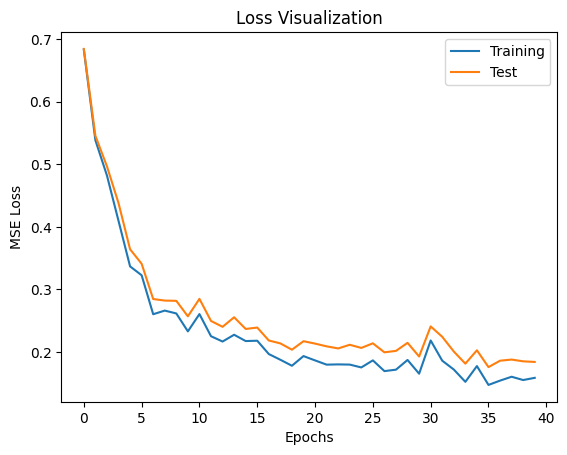

In [14]:
#Visualize training vs test loss
import matplotlib.pyplot as plt
with torch.no_grad():
    fig, ax = plt.subplots()

    ax.plot(train_loss, label="Training")
    ax.plot(test_loss, label="Test")
    ax.legend(loc=0); # upper left corner
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE Loss')
    ax.set_title('Loss Visualization')
    #plt.plot(train_loss, label = 'Training')
    #plt.plot(test_loss, label = 'Test')

In [15]:
#From our loss visualization, we should probably reduce the learning rate

#Calculate R2 metric for both training and test
with torch.no_grad():
    print(f'train r2: {sklearn.metrics.r2_score(model(X_train), Y_train)} ')
    print(f'test r2: {sklearn.metrics.r2_score(model(X_test), Y_test)}')

train r2: 0.8946136803183289 
test r2: 0.875757498424563


In [297]:
#Test run of deep learning model using logo cross validation

#Large learning rate and small num_epochs until on monsoon

#increased num_epochs should drastically increase accuracy. 

for i,sitename in zip(iter,uni):
    ## data setup
    print(sitename)
    df_test = df[df['Site'] == sitename]
    df_train = df[df['Site'] != sitename]

    x_train = df_train.drop(df_train.filter(regex='FC|NEE|Site').columns, axis=1)
    y_train = df_train['FC50']
    x_test = df_test.drop(df_test.filter(regex='FC|NEE|Site').columns, axis=1)
    y_test = df_test['FC50']

    Y_train = torch.Tensor(y_train.values).reshape(-1,1)
    X_train = torch.Tensor(x_train.values)
    Y_test = torch.Tensor(y_test.values).reshape(-1,1)
    X_test = torch.Tensor(x_test.values)
    # Model 
    model = Linear(X_train.shape[1])
  

    loss_fn = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(),lr =0.001, weight_decay = 0)

    train_data = FluxData(X_train,Y_train)
    
    train_loader = DataLoader(dataset=train_data,
                              batch_size=100,
                              shuffle=True,
                              num_workers=0)
    
    model.train()
    num_epochs = 100
    for epoch in range(num_epochs):
        for j,(inputs, labels) in enumerate(train_loader):
            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    
    with torch.no_grad():
        # Set the model to evaluation mode
        model.eval()
        
        # Make predictions
        outputs = model(X_test)
        outputs_train=model(X_train)
        
        
        # Calculate accuracy for this fold
        score =  r2_score(outputs, Y_test)
        mse = mean_squared_error(outputs,Y_test)
        
        print(f"Fold {i} R2_test: {score} Mse: {mse} ")
        

    

PR-xGU
Fold 1 R2_test: 0.4050354279025148 Mse: 0.6000657081604004 
PR-xLA
Fold 2 R2_test: 0.6565455146464241 Mse: 0.43790438771247864 
US-xAB
Fold 3 R2_test: 0.5706369419958706 Mse: 0.438024640083313 
US-xAE
Fold 4 R2_test: 0.44944453453304245 Mse: 0.47097718715667725 
US-xBA
Fold 5 R2_test: 0.5548741709462242 Mse: 0.48954054713249207 


In [ ]:
#Start looking at step-wise regression
import numpy as np
import statsmodels.api as sm

def get_stats(x,y):
    x = x
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats(x,y)

                                 OLS Regression Results                                
Dep. Variable:                     FC   R-squared (uncentered):                   0.582
Model:                            OLS   Adj. R-squared (uncentered):              0.581
Method:                 Least Squares   F-statistic:                              3270.
Date:                Tue, 23 May 2023   Prob (F-statistic):                        0.00
Time:                        12:30:50   Log-Likelihood:                     -1.8644e+05
No. Observations:              181215   AIC:                                  3.730e+05
Df Residuals:                  181138   BIC:                                  3.738e+05
Df Model:                          77                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------